<h1 style="background-color: #001f3f; color: #ff0; padding: 12px; border: 2px solid #fff; text-align: center;border-radius: 8px;">House Price</h1>

In [1]:
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import numpy as np 
from scipy import stats
from scipy.stats import norm, probplot
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score

#Visualization Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


<h4 style="background-color: #001f3f; color: #ff0; padding: 10px; border: 2px solid #fff; display: inline-block; margin-bottom: 5px;">DATA PREPROCESS</h4>

In [2]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [3]:
train.shape

(1460, 81)

In [4]:
test.shape

(1459, 80)

In [5]:
print(' We Have {} Columns : \n \n {}'.format(len(train.columns),train.columns.values))

 We Have 81 Columns : 
 
 ['Id' 'MSSubClass' 'MSZoning' 'LotFrontage' 'LotArea' 'Street' 'Alley'
 'LotShape' 'LandContour' 'Utilities' 'LotConfig' 'LandSlope'
 'Neighborhood' 'Condition1' 'Condition2' 'BldgType' 'HouseStyle'
 'OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd' 'RoofStyle'
 'RoofMatl' 'Exterior1st' 'Exterior2nd' 'MasVnrType' 'MasVnrArea'
 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure'
 'BsmtFinType1' 'BsmtFinSF1' 'BsmtFinType2' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' '1stFlrSF'
 '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath'
 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'KitchenQual'
 'TotRmsAbvGrd' 'Functional' 'Fireplaces' 'FireplaceQu' 'GarageType'
 'GarageYrBlt' 'GarageFinish' 'GarageCars' 'GarageArea' 'GarageQual'
 'GarageCond' 'PavedDrive' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'PoolQC' 'Fence' 'MiscFeature'
 'MiscVal'

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
cat_cols = train.select_dtypes(include=['object', 'O']).columns

num_cols = train.select_dtypes(include=['int64', 'float64'])

for feature in num_cols:
    zero_values = (train[feature] == 0).sum()
    null_values = train[feature].isnull().sum()
    unique_values = len(train[feature].unique())

    print(f"Feature: {feature}")
    print(f"Number of 0 Values: {zero_values}")
    print(f"Number of Null Values: {null_values}")
    print(f"Unique Values: {unique_values}")
    print("="*30)

Feature: Id
Number of 0 Values: 0
Number of Null Values: 0
Unique Values: 1460
Feature: MSSubClass
Number of 0 Values: 0
Number of Null Values: 0
Unique Values: 15
Feature: LotFrontage
Number of 0 Values: 0
Number of Null Values: 259
Unique Values: 111
Feature: LotArea
Number of 0 Values: 0
Number of Null Values: 0
Unique Values: 1073
Feature: OverallQual
Number of 0 Values: 0
Number of Null Values: 0
Unique Values: 10
Feature: OverallCond
Number of 0 Values: 0
Number of Null Values: 0
Unique Values: 9
Feature: YearBuilt
Number of 0 Values: 0
Number of Null Values: 0
Unique Values: 112
Feature: YearRemodAdd
Number of 0 Values: 0
Number of Null Values: 0
Unique Values: 61
Feature: MasVnrArea
Number of 0 Values: 861
Number of Null Values: 8
Unique Values: 328
Feature: BsmtFinSF1
Number of 0 Values: 467
Number of Null Values: 0
Unique Values: 637
Feature: BsmtFinSF2
Number of 0 Values: 1293
Number of Null Values: 0
Unique Values: 144
Feature: BsmtUnfSF
Number of 0 Values: 118
Number of Nu

In [8]:
for col in train.select_dtypes('O').columns:
    print('We Have {} Unique Values. Values in {} Column : {}'.format(len(train[col].unique()),col,train[col].unique()))
    print('__'*30)

We Have 5 Unique Values. Values in MSZoning Column : ['RL' 'RM' 'C (all)' 'FV' 'RH']
____________________________________________________________
We Have 2 Unique Values. Values in Street Column : ['Pave' 'Grvl']
____________________________________________________________
We Have 3 Unique Values. Values in Alley Column : [nan 'Grvl' 'Pave']
____________________________________________________________
We Have 4 Unique Values. Values in LotShape Column : ['Reg' 'IR1' 'IR2' 'IR3']
____________________________________________________________
We Have 4 Unique Values. Values in LandContour Column : ['Lvl' 'Bnk' 'Low' 'HLS']
____________________________________________________________
We Have 2 Unique Values. Values in Utilities Column : ['AllPub' 'NoSeWa']
____________________________________________________________
We Have 5 Unique Values. Values in LotConfig Column : ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
____________________________________________________________
We Have 3 Unique Val

# Missing Values

In [9]:
train.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [10]:
test.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64

In [11]:
null_train_data = round(100*(train.isnull().sum().sort_values(ascending=False)/len(train.index)),2)\
                    .to_frame().rename(columns={0:'Train Null values percentage'})[:19]
null_train_data

,Train Null values percentage
PoolQC,99.52
MiscFeature,96.30
Alley,93.77
Fence,80.75
MasVnrType,59.73
FireplaceQu,47.26
LotFrontage,17.74
GarageYrBlt,5.55
GarageCond,5.55
GarageType,5.55


In [12]:
null_test_data = round(100*(test.isnull().sum().sort_values(ascending=False)/len(test.index)),2)\
                    .to_frame().rename(columns={0:'Test Null values percentage'})[:25]
null_test_data

,Test Null values percentage
PoolQC,99.79
MiscFeature,96.50
Alley,92.67
Fence,80.12
MasVnrType,61.27
FireplaceQu,50.03
LotFrontage,15.56
GarageYrBlt,5.35
GarageQual,5.35
GarageFinish,5.35


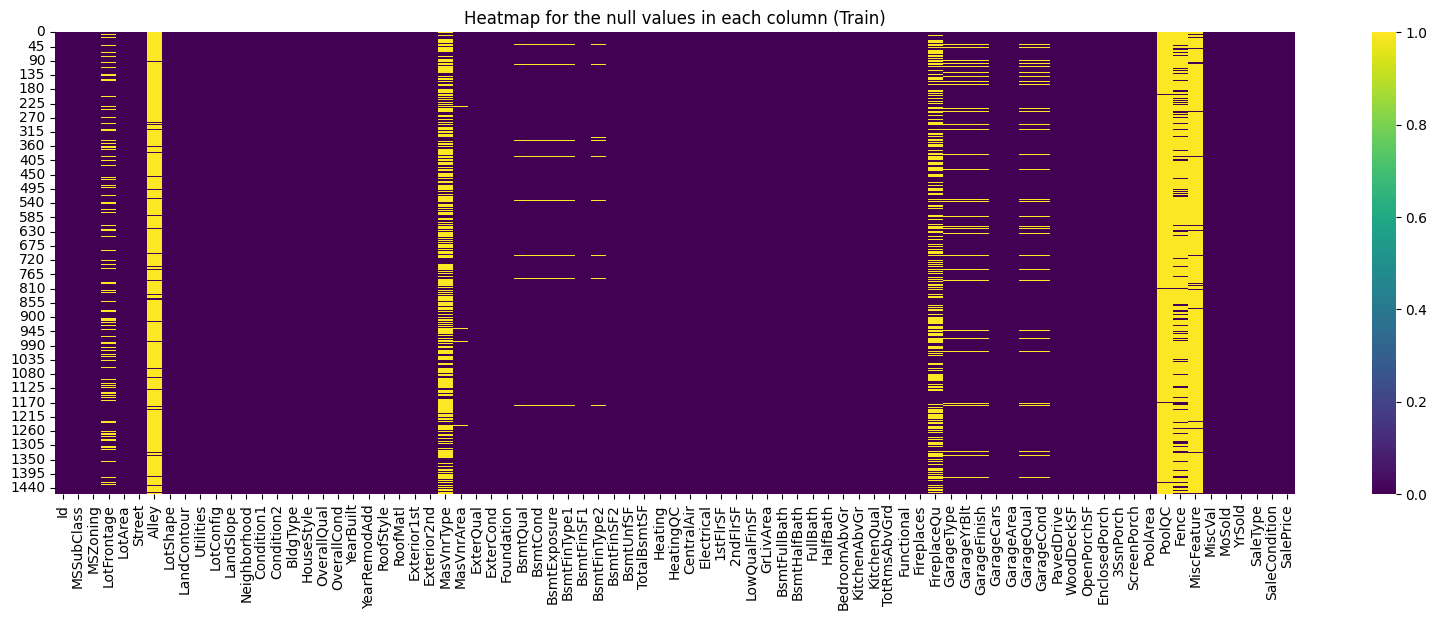

In [13]:
plt.figure(figsize=(20,6))
plt.title('Heatmap for the null values in each column (Train)')
sns.heatmap(train.isnull(),cmap='viridis');

In [14]:
# When we examine the txt file, we see that the MSSubClass column should actually be categorical.
train["MSSubClass"] = train["MSSubClass"].astype("object")
test["MSSubClass"] = test["MSSubClass"].astype("object")


## Filling the Train dataset

In [15]:
train["PoolQC"] = train["PoolQC"].fillna("NA")
train["MiscFeature"] = train["MiscFeature"].fillna("NA")
train["Alley"] = train["Alley"].fillna("NA")
train["Fence"] = train["Fence"].fillna("NA")
train["FireplaceQu"] = train["FireplaceQu"].fillna("NA")
train["MasVnrType"] = train["MasVnrType"].fillna("NA")
train["MasVnrArea"] = train["MasVnrArea"].fillna(0)
train["Functional"] = train["Functional"].fillna("Typ")


train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])
train['KitchenQual'] = train['KitchenQual'].fillna(train['KitchenQual'].mode()[0])
train['Exterior1st'] = train['Exterior1st'].fillna(train['Exterior1st'].mode()[0])
train['Exterior2nd'] = train['Exterior2nd'].fillna(train['Exterior2nd'].mode()[0])
train['SaleType'] = train['SaleType'].fillna(train['SaleType'].mode()[0])
train['MSZoning'] = train['MSZoning'].fillna(train['MSZoning'].mode()[0])
train['Utilities'] = train['Utilities'].fillna(train['Utilities'].mode()[0])
train['SaleType'] = train['SaleType'].fillna(train['SaleType'].mode()[0])

train['MSSubClass'] = train['MSSubClass'].fillna("NA")

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train[col] = train[col].fillna('NA')
# Since there is no garage, I fill the null values with 0.
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train[col] = train[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    train[col] = train[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train[col] = train[col].fillna('NA')

## Filling the Test dataset

In [16]:
test["PoolQC"] = test["PoolQC"].fillna("NA")
test["MiscFeature"] = test["MiscFeature"].fillna("NA")
test["Alley"] = test["Alley"].fillna("NA")
test["Fence"] = test["Fence"].fillna("NA")
test["FireplaceQu"] = test["FireplaceQu"].fillna("NA")
test["MasVnrType"] = test["MasVnrType"].fillna("NA")
test["MasVnrArea"] = test["MasVnrArea"].fillna(0)
test["Functional"] = test["Functional"].fillna("Typ")


test['Electrical'] = test['Electrical'].fillna(test['Electrical'].mode()[0])
test['KitchenQual'] = test['KitchenQual'].fillna(test['KitchenQual'].mode()[0])
test['Exterior1st'] = test['Exterior1st'].fillna(test['Exterior1st'].mode()[0])
test['Exterior2nd'] = test['Exterior2nd'].fillna(test['Exterior2nd'].mode()[0])
test['SaleType'] = test['SaleType'].fillna(test['SaleType'].mode()[0])
test['MSZoning'] = test['MSZoning'].fillna(test['MSZoning'].mode()[0])
test['Utilities'] = test['Utilities'].fillna(test['Utilities'].mode()[0])
test['SaleType'] = test['SaleType'].fillna(test['SaleType'].mode()[0])

train['MSSubClass'] = train['MSSubClass'].fillna("NA")

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    test[col] = test[col].fillna('NA')
# Since there is no garage, I fill the null values with 0.
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    test[col] = test[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    test[col] = test[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    test[col] = test[col].fillna('NA')

### I am checking the compatibility between the Neighborhood and LotFrontage columns

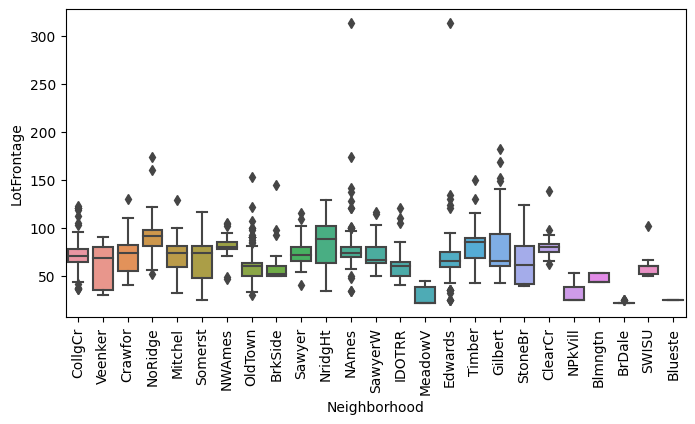

In [17]:
plt.figure(figsize = (8, 4), dpi = 100)
sns.boxplot(x = "Neighborhood", y = "LotFrontage", data = train)
plt.xticks(rotation = 90)
plt.show()

**Each category is unique enough to make the assumption that we can assign LotFrontage by Neighborhood categories.**


**We will have data as below**

In [18]:
train.groupby("Neighborhood")["LotFrontage"].mean()

Neighborhood
Blmngtn    47.142857
Blueste    24.000000
BrDale     21.562500
BrkSide    57.509804
ClearCr    83.461538
CollgCr    71.682540
Crawfor    71.804878
Edwards    68.217391
Gilbert    79.877551
IDOTRR     62.500000
MeadowV    27.800000
Mitchel    70.083333
NAmes      76.462366
NPkVill    32.285714
NWAmes     81.288889
NoRidge    91.878788
NridgHt    81.881579
OldTown    62.788991
SWISU      58.913043
Sawyer     74.437500
SawyerW    71.500000
Somerst    64.666667
StoneBr    62.700000
Timber     80.133333
Veenker    59.714286
Name: LotFrontage, dtype: float64

In [19]:
test.groupby("Neighborhood")["LotFrontage"].mean()

Neighborhood
Blmngtn    46.333333
Blueste    28.125000
BrDale     21.428571
BrkSide    53.795455
ClearCr    96.857143
CollgCr    70.872340
Crawfor    68.142857
Edwards    65.511628
Gilbert    69.725806
IDOTRR     62.075472
MeadowV    23.777778
Mitchel    78.518519
NAmes      73.978836
NPkVill    26.071429
NWAmes     81.775000
NoRidge    91.238095
NridgHt    86.195402
OldTown    60.858333
SWISU      59.238095
Sawyer     74.660000
SawyerW    69.928571
Somerst    64.440476
StoneBr    61.769231
Timber     82.296296
Veenker    81.555556
Name: LotFrontage, dtype: float64

In [20]:
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(lambda value: value.fillna(value.mean()))
test["LotFrontage"] = test.groupby("Neighborhood")["LotFrontage"].transform(lambda value: value.fillna(value.mean()))

In [21]:
train.isnull().sum().max()

0

In [22]:
test.isnull().sum().max()

0

# Correlation

**Correlation Analysis with SalePrice (Descending)**

In [23]:
# Calculating the correlation between numerical columns.
corr = num_cols.corr()

# Sorting and selecting the correlations with the 'SalePrice' column and choosing the top 15.
# We selected the top 15 because they are the most influential, meaning they have the highest correlations.
top_corr = corr['SalePrice'].sort_values(ascending=False)[1:15].to_frame()

# Using background gradient to visualize the output with colors.
styled_corr = top_corr.style.background_gradient(axis=1, cmap=sns.light_palette('green', as_cmap=True))

styled_corr

,SalePrice
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


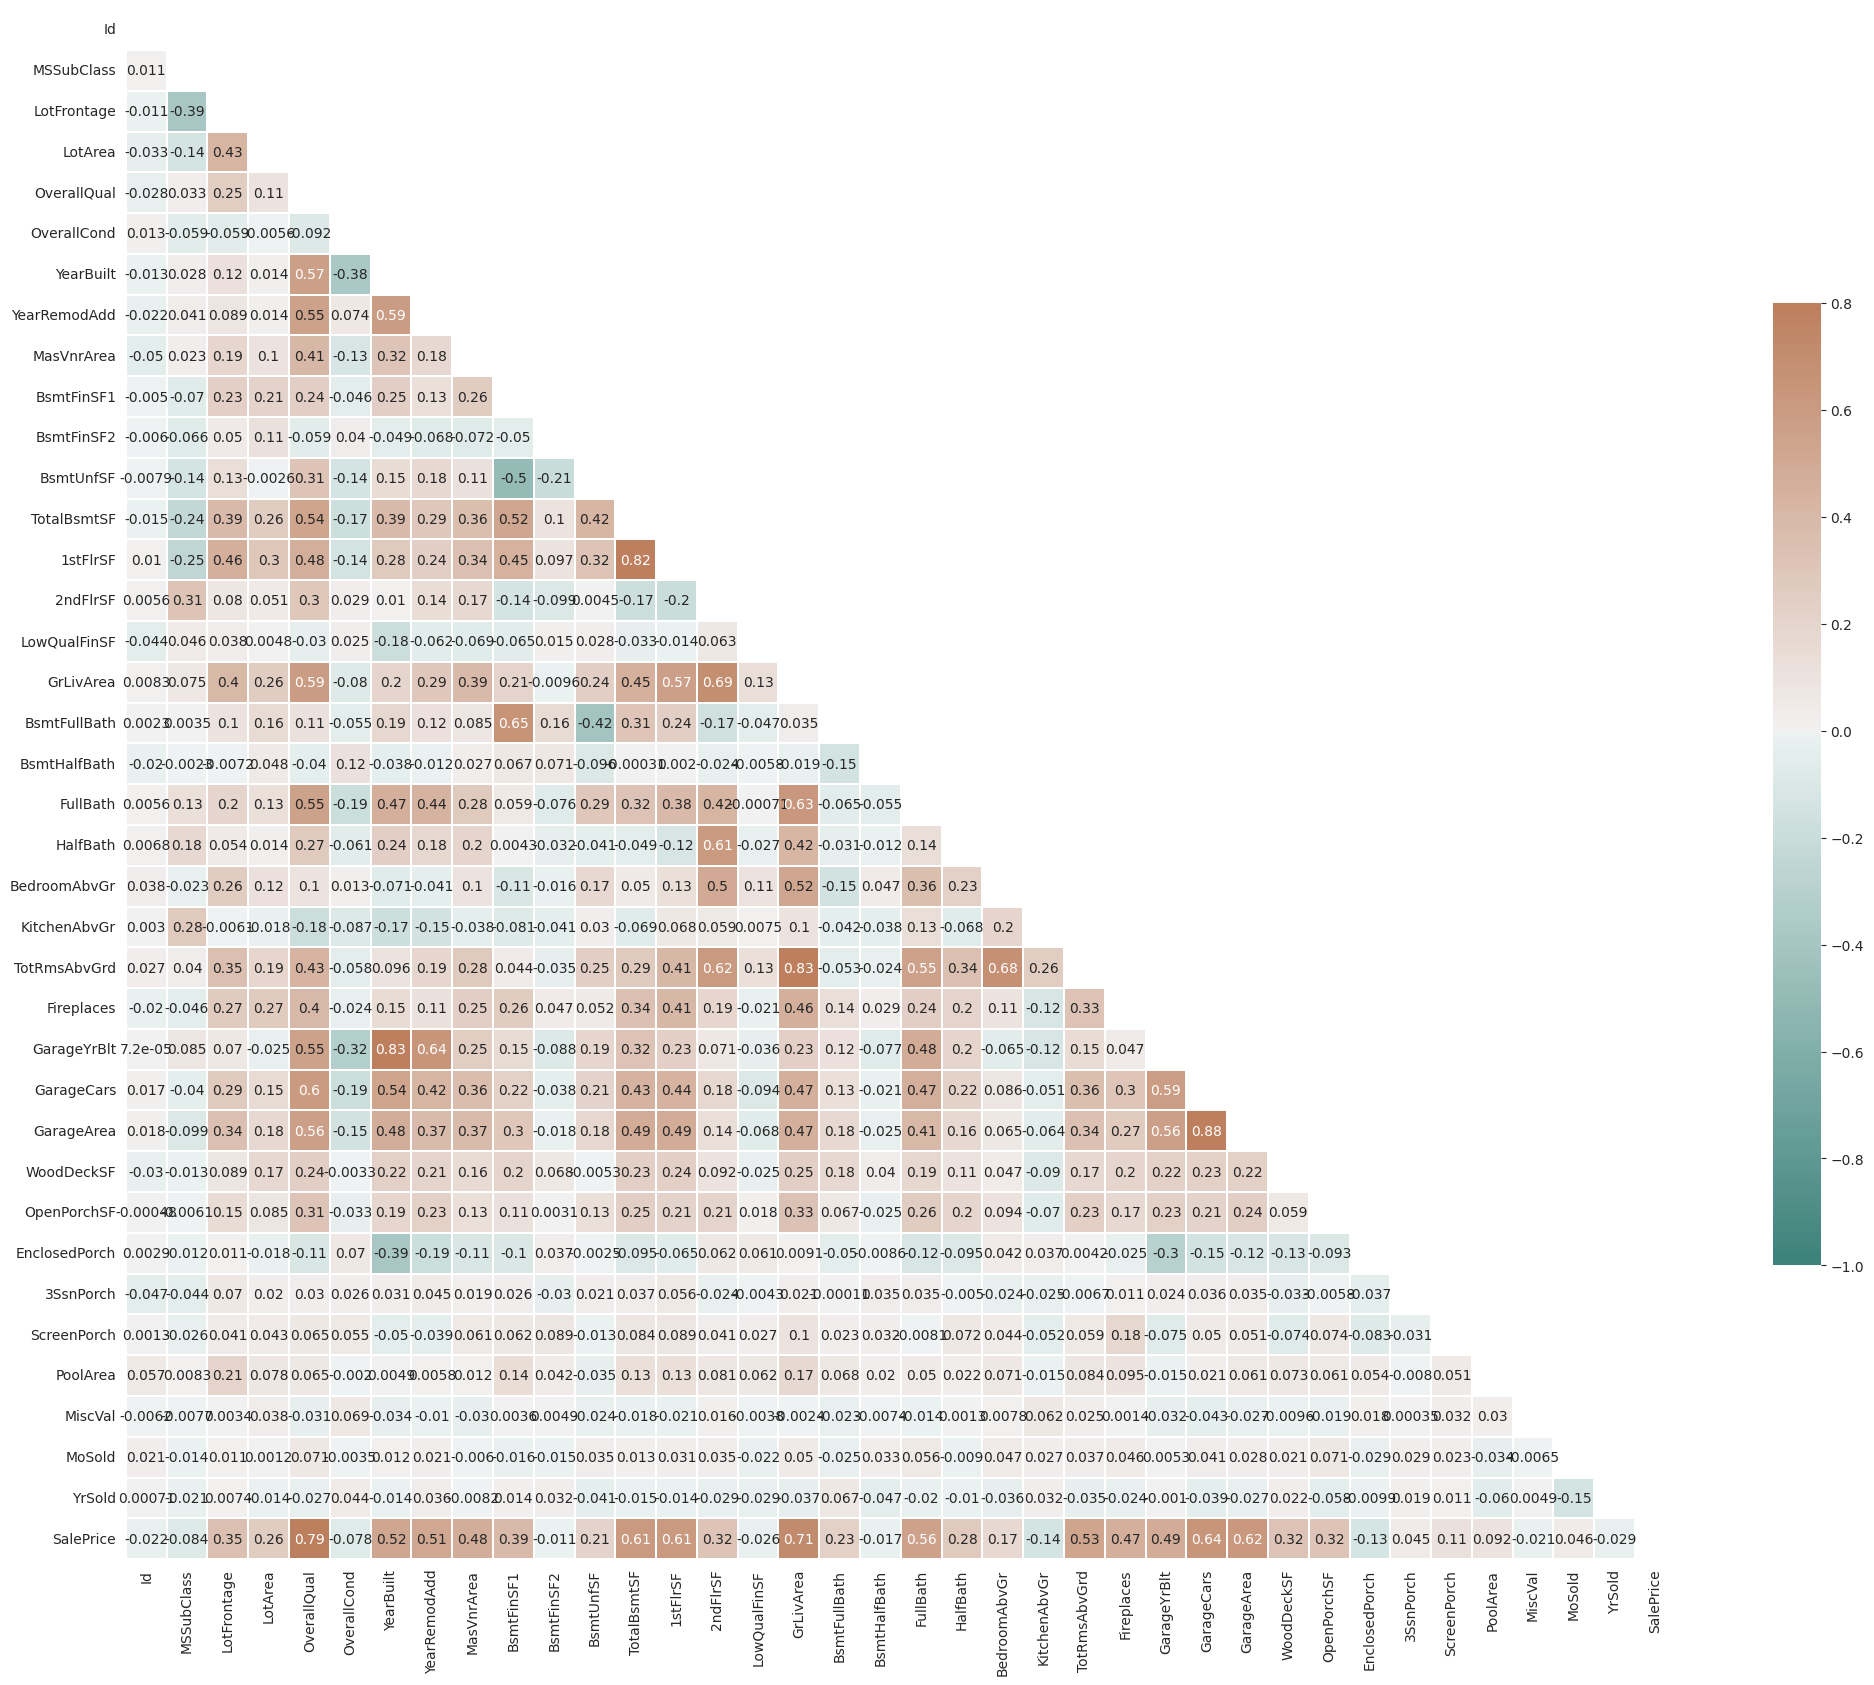

In [24]:
# Calculating the correlation between numerical columns
corr = num_cols.corr()

# Creating a mask for the correlation
# We mask the upper triangle since we don't want to display it
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Creating a color palette and generating the heatmap figure
cmap = sns.diverging_palette(180, 30, as_cmap=True)

# Creating and visualizing the heatmap
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(25, 25))

    # Create a heatmap with annotations, and apply the mask
    sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, center=0, vmin=-1, vmax=0.8,
                square=True, cbar_kws={'shrink': 0.5, 'orientation': 'vertical'}, linewidth=.02)

# Displaying the plot
plt.show()

# Outliers

#### GrLivArea

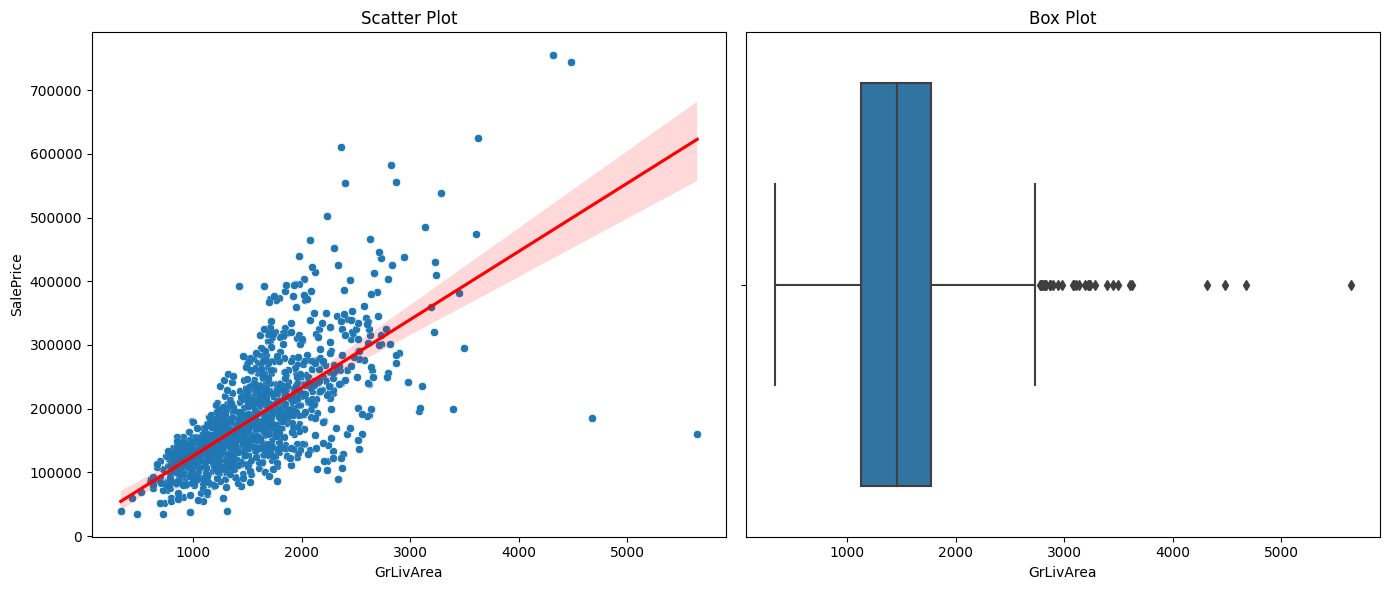

In [25]:
plt.figure(figsize=(14, 6), dpi=100)

# Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=train, x="GrLivArea", y="SalePrice")
sns.regplot(data=train, x="GrLivArea", y="SalePrice", scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Scatter Plot')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(data=train, x="GrLivArea")
plt.title('Box Plot')


plt.tight_layout() 
plt.show()

In [26]:
train.query('GrLivArea > 4500')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NA,IR1,Bnk,AllPub,...,0,NA,NA,NA,0,10,2007,New,Partial,184750
1298,1299,60,RL,313.0,63887,Pave,NA,IR3,Bnk,AllPub,...,480,Gd,NA,NA,0,1,2008,New,Partial,160000


In [27]:
from scipy import stats

z_scores = stats.zscore(train['GrLivArea'])
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3)
outlier_indices = np.where(outliers)[0]

outlier_values = train['GrLivArea'].iloc[outlier_indices]
sorted_outlier_values_descending = outlier_values.sort_values(ascending=False)

print(sorted_outlier_values_descending)

1298    5642
523     4676
1182    4476
691     4316
1169    3627
185     3608
304     3493
1268    3447
635     3395
769     3279
1353    3238
496     3228
118     3222
608     3194
798     3140
197     3112
Name: GrLivArea, dtype: int64


#### TotalBsmtSF

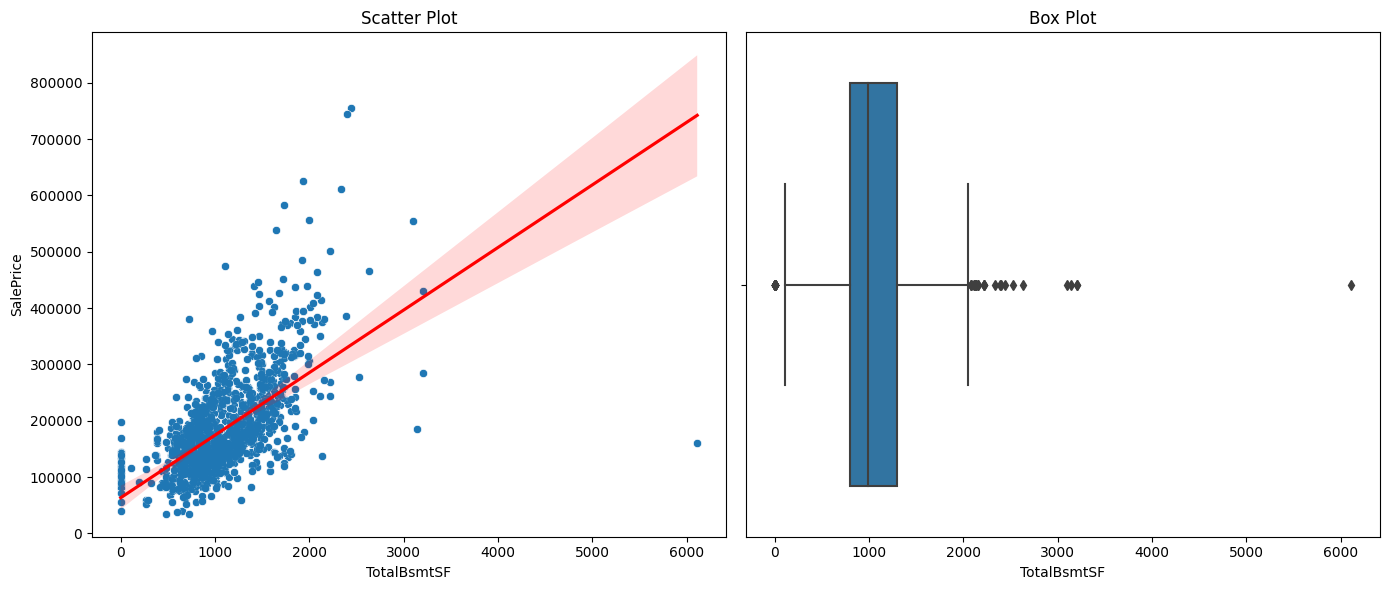

In [28]:
plt.figure(figsize=(14, 6), dpi=100)

# Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=train, x="TotalBsmtSF", y="SalePrice")
sns.regplot(data=train, x="TotalBsmtSF", y="SalePrice", scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Scatter Plot')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(data=train, x="TotalBsmtSF")
plt.title('Box Plot')


plt.tight_layout()
plt.show()

In [29]:
train.query('TotalBsmtSF > 5500')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NA,IR3,Bnk,AllPub,...,480,Gd,NA,NA,0,1,2008,New,Partial,160000


In [30]:
from scipy import stats

z_scores = stats.zscore(train['TotalBsmtSF'])
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3)
outlier_indices = np.where(outliers)[0]

outlier_values = train['TotalBsmtSF'].iloc[outlier_indices]
sorted_outlier_values_descending = outlier_values.sort_values(ascending=False)

print(sorted_outlier_values_descending)

1298    6110
332     3206
496     3200
523     3138
440     3094
1373    2633
1044    2524
691     2444
1182    2396
224     2392
Name: TotalBsmtSF, dtype: int64


#### LotFrontage

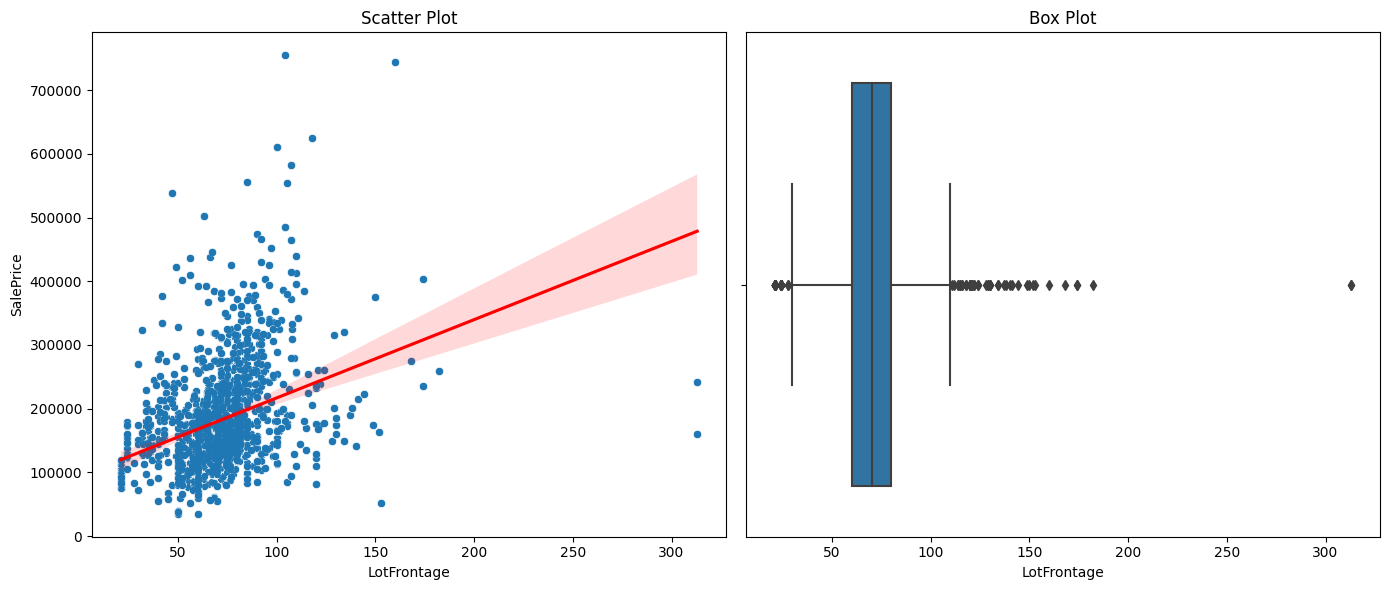

In [31]:
plt.figure(figsize=(14, 6), dpi=100)

# Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=train, x="LotFrontage", y="SalePrice")
sns.regplot(data=train, x="LotFrontage", y="SalePrice", scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Scatter Plot')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(data=train, x="LotFrontage")
plt.title('Box Plot')


plt.tight_layout()
plt.show()

In [32]:
train.query('(SalePrice < 100000) & (LotFrontage > 150)')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1337,1338,30,RM,153.0,4118,Pave,Grvl,IR1,Bnk,AllPub,...,0,NA,NA,NA,0,3,2006,WD,Normal,52500


In [33]:
train.query('LotFrontage > 300')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
934,935,20,RL,313.0,27650,Pave,NA,IR2,HLS,AllPub,...,0,NA,NA,NA,0,11,2008,WD,Normal,242000
1298,1299,60,RL,313.0,63887,Pave,NA,IR3,Bnk,AllPub,...,480,Gd,NA,NA,0,1,2008,New,Partial,160000


In [34]:
from scipy import stats

z_scores = stats.zscore(train['LotFrontage'])
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3)
outlier_indices = np.where(outliers)[0]

outlier_values = train['LotFrontage'].iloc[outlier_indices]
sorted_outlier_values_descending = outlier_values.sort_values(ascending=False)

print(sorted_outlier_values_descending)

934     313.0
1298    313.0
1127    182.0
197     174.0
231     174.0
1107    168.0
1182    160.0
1337    153.0
1211    152.0
313     150.0
909     149.0
807     144.0
171     141.0
277     140.0
1173    138.0
Name: LotFrontage, dtype: float64


#### LotArea

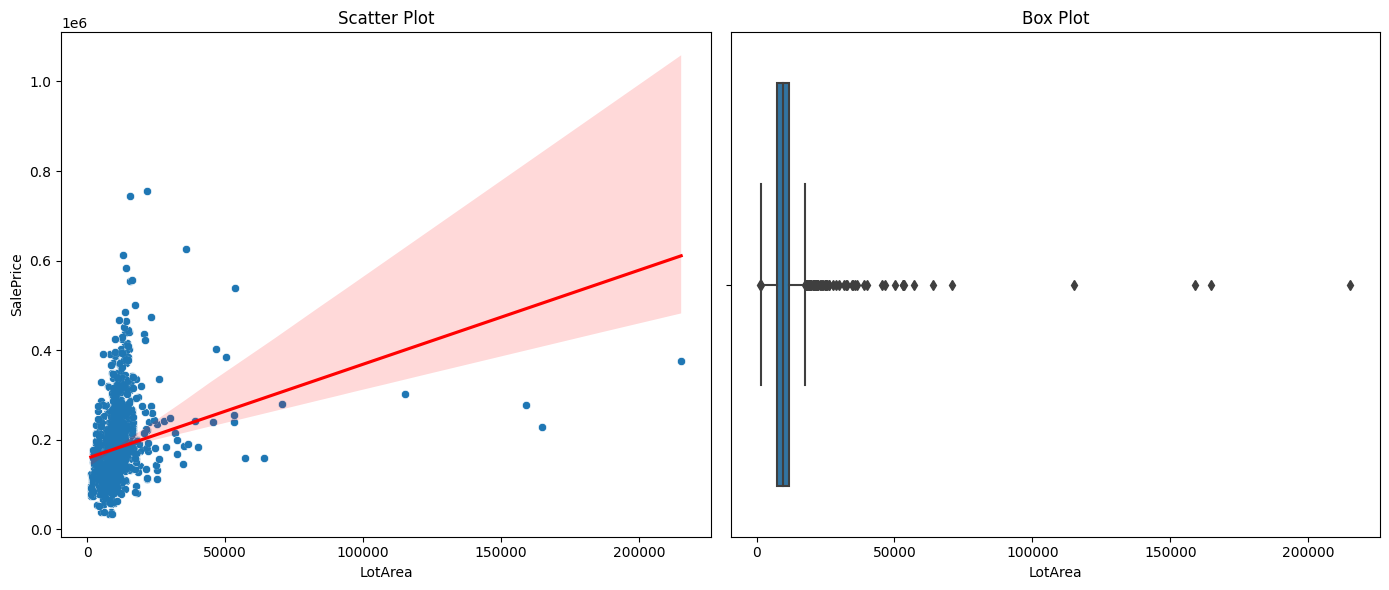

In [35]:
plt.figure(figsize=(14, 6), dpi=100)

# Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=train, x="LotArea", y="SalePrice")
sns.regplot(data=train, x="LotArea", y="SalePrice", scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Scatter Plot')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(data=train, x="LotArea")
plt.title('Box Plot')


plt.tight_layout()
plt.show()

In [36]:
train.query('LotArea > 55000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
249,250,50,RL,83.461538,159000,Pave,NA,IR2,Low,AllPub,...,0,NA,NA,Shed,500,6,2007,WD,Normal,277000
313,314,20,RL,150.000000,215245,Pave,NA,IR3,Low,AllPub,...,0,NA,NA,NA,0,6,2009,WD,Normal,375000
335,336,190,RL,80.133333,164660,Grvl,NA,IR1,HLS,AllPub,...,0,NA,NA,Shed,700,8,2008,WD,Normal,228950
451,452,20,RL,62.000000,70761,Pave,NA,IR1,Low,AllPub,...,0,NA,NA,NA,0,12,2006,WD,Normal,280000
706,707,20,RL,83.461538,115149,Pave,NA,IR2,Low,AllPub,...,0,NA,NA,NA,0,6,2007,WD,Normal,302000
1298,1299,60,RL,313.000000,63887,Pave,NA,IR3,Bnk,AllPub,...,480,Gd,NA,NA,0,1,2008,New,Partial,160000
1396,1397,20,RL,80.133333,57200,Pave,NA,IR1,Bnk,AllPub,...,0,NA,NA,NA,0,6,2010,WD,Normal,160000


In [37]:
from scipy import stats

z_scores = stats.zscore(train['LotArea'])
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3)
outlier_indices = np.where(outliers)[0]

outlier_values = train['LotArea'].iloc[outlier_indices]
sorted_outlier_values_descending = outlier_values.sort_values(ascending=False)

print(sorted_outlier_values_descending)

313     215245
335     164660
249     159000
706     115149
451      70761
1298     63887
1396     57200
769      53504
457      53227
384      53107
53       50271
661      46589
848      45600
Name: LotArea, dtype: int64


#### YearBuilt

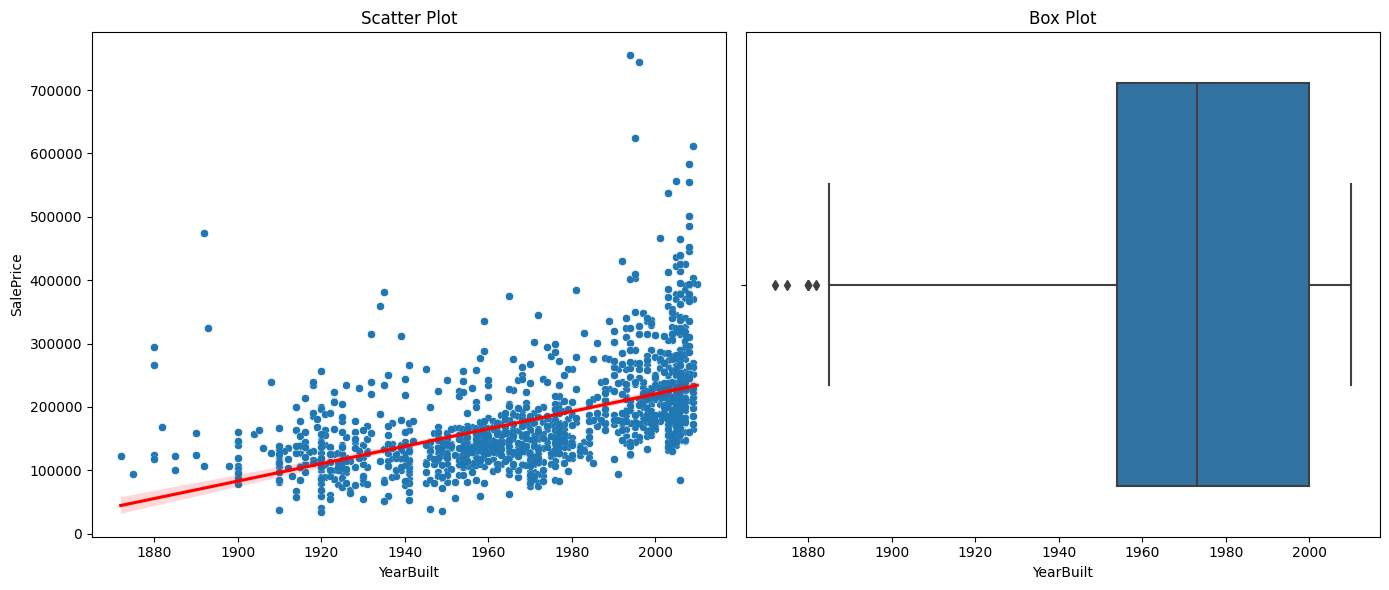

In [38]:
plt.figure(figsize=(14, 6), dpi=100)

# Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=train, x="YearBuilt", y="SalePrice")
sns.regplot(data=train, x="YearBuilt", y="SalePrice", scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Scatter Plot')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(data=train, x="YearBuilt")
plt.title('Box Plot')


plt.tight_layout()
plt.show()

In [39]:
train.query('YearBuilt < 1900 & SalePrice > 200000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
185,186,75,RM,90.0,22950,Pave,NA,IR2,Lvl,AllPub,...,0,NA,GdPrv,NA,0,6,2006,WD,Normal,475000
304,305,75,RM,87.0,18386,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2008,WD,Normal,295000
583,584,75,RM,75.0,13500,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,7,2008,WD,Normal,325000
747,748,70,RM,65.0,11700,Pave,Pave,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,5,2009,WD,Normal,265979


In [40]:
z_scores = stats.zscore(train['YearBuilt'])
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3)
outlier_indices = np.where(outliers)[0]

outlier_values = train['YearBuilt'].iloc[outlier_indices]
sorted_outlier_values_descending = outlier_values.sort_values(ascending=False)

print(sorted_outlier_values_descending)

304     1880
630     1880
747     1880
1132    1880
1137    1875
1349    1872
Name: YearBuilt, dtype: int64


#### MasVnrArea

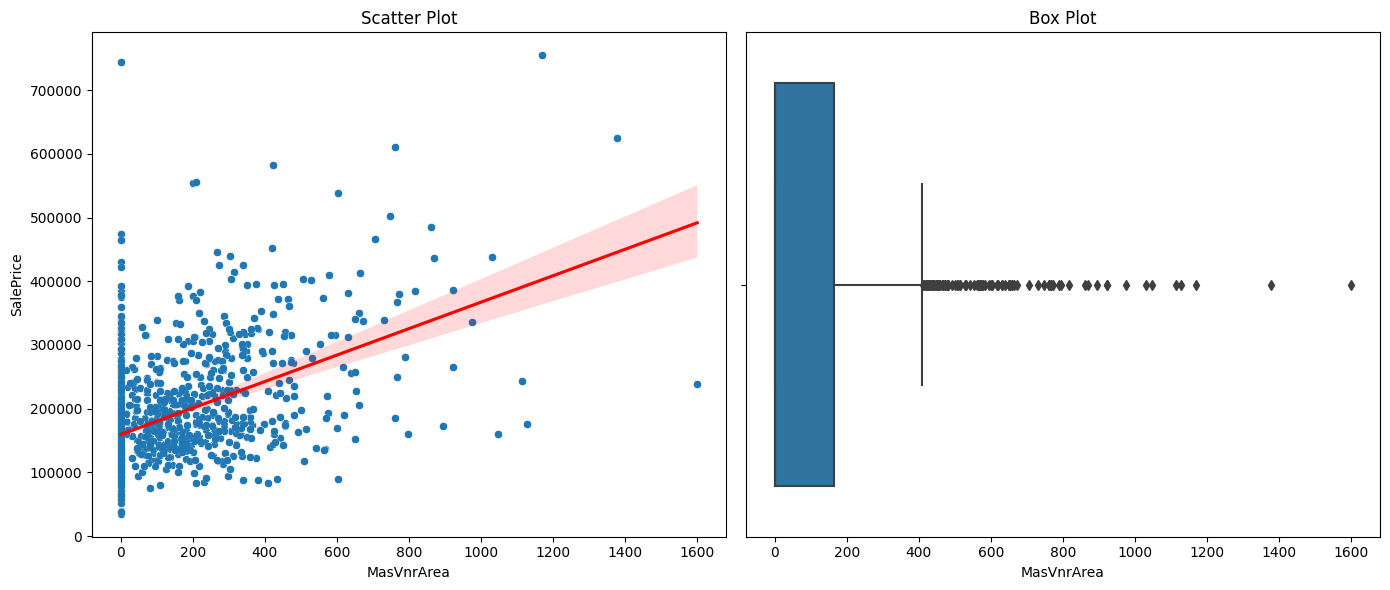

In [41]:
plt.figure(figsize=(14, 6), dpi=100)

# Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=train, x="MasVnrArea", y="SalePrice")
sns.regplot(data=train, x="MasVnrArea", y="SalePrice", scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Scatter Plot')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(data=train, x="MasVnrArea")
plt.title('Box Plot')


plt.tight_layout()
plt.show()

In [42]:
train.query('MasVnrArea > 1500')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
297,298,60,FV,66.0,7399,Pave,Pave,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,6,2007,WD,Normal,239000


In [43]:
z_scores = stats.zscore(train['MasVnrArea'])
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3)
outlier_indices = np.where(outliers)[0]

outlier_values = train['MasVnrArea'].iloc[outlier_indices]
sorted_outlier_values_descending = outlier_values.sort_values(ascending=False)

print(sorted_outlier_values_descending)

297     1600.0
1169    1378.0
691     1170.0
115     1129.0
70      1115.0
808     1047.0
58      1031.0
981      975.0
224      922.0
517      921.0
755      894.0
349      870.0
798      860.0
825      816.0
1298     796.0
1289     788.0
477      772.0
105      768.0
1228     766.0
523      762.0
898      760.0
178      748.0
1417     731.0
1373     705.0
763      673.0
161      664.0
1111     660.0
654      660.0
169      653.0
718      651.0
403      650.0
37       650.0
Name: MasVnrArea, dtype: float64


#### BsmtFinSF1

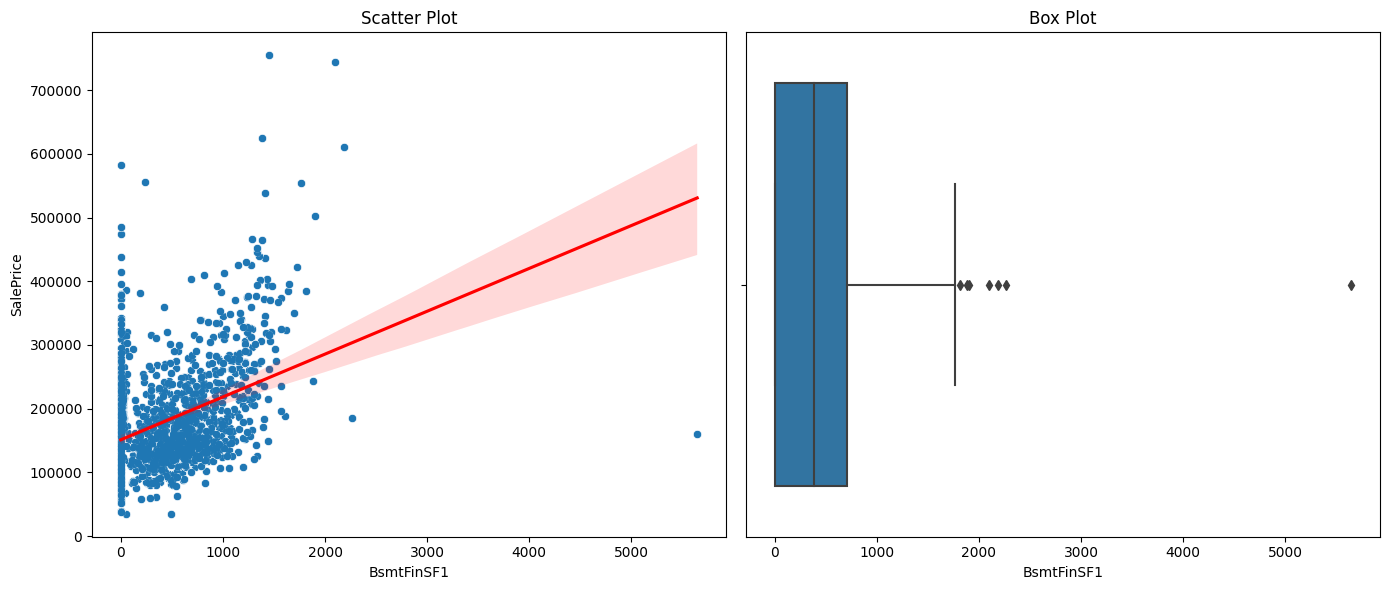

In [44]:
plt.figure(figsize=(14, 6), dpi=100)

# Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=train, x="BsmtFinSF1", y="SalePrice")
sns.regplot(data=train, x="BsmtFinSF1", y="SalePrice", scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Scatter Plot')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(data=train, x="BsmtFinSF1")
plt.title('Box Plot')


plt.tight_layout()
plt.show()

In [45]:
train.query('BsmtFinSF1 > 5000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NA,IR3,Bnk,AllPub,...,480,Gd,NA,NA,0,1,2008,New,Partial,160000


In [46]:
z_scores = stats.zscore(train['BsmtFinSF1'])
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3)
outlier_indices = np.where(outliers)[0]

outlier_values = train['BsmtFinSF1'].iloc[outlier_indices]
sorted_outlier_values_descending = outlier_values.sort_values(ascending=False)

print(sorted_outlier_values_descending)

1298    5644
523     2260
898     2188
1182    2096
178     1904
70      1880
Name: BsmtFinSF1, dtype: int64


#### BsmtFinSF2

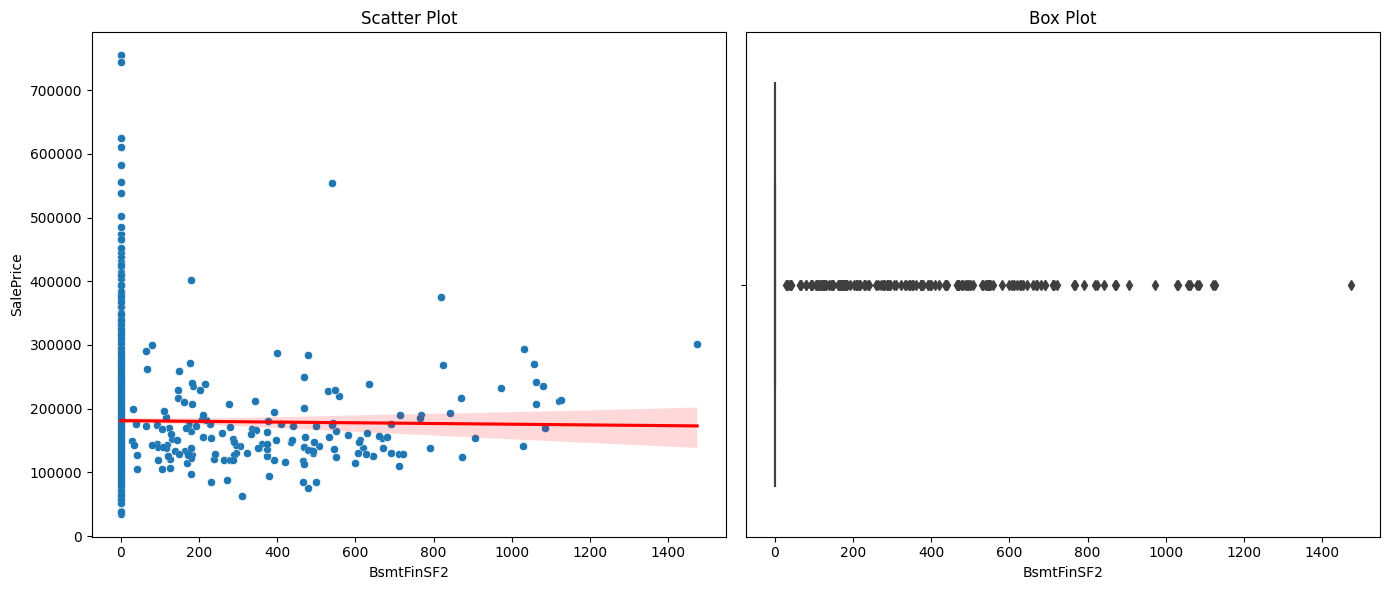

In [47]:
plt.figure(figsize=(14, 6), dpi=100)

# Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=train, x="BsmtFinSF2", y="SalePrice")
sns.regplot(data=train, x="BsmtFinSF2", y="SalePrice", scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Scatter Plot')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(data=train, x="BsmtFinSF2")
plt.title('Box Plot')


plt.tight_layout()
plt.show()

In [48]:
train.query('BsmtFinSF2 > 400 & SalePrice > 500000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
440,441,20,RL,105.0,15431,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,4,2009,WD,Normal,555000


In [49]:
z_scores = stats.zscore(train['BsmtFinSF2'])
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3)
outlier_indices = np.where(outliers)[0]

outlier_values = train['BsmtFinSF2'].iloc[outlier_indices]
sorted_outlier_values_descending = outlier_values.sort_values(ascending=False)

print(sorted_outlier_values_descending)

322     1474
542     1127
470     1120
854     1085
153     1080
271     1063
924     1061
764     1057
1253    1031
1458    1029
1369     972
1299     906
1418     872
113      869
923      841
888      823
313      820
1077     791
166      768
828      764
666      723
446      713
233      712
52       712
263      692
260      690
1040     682
116      670
24       668
1320     661
548      645
918      634
785      630
1445     627
273      620
599      612
1308     608
586      606
1220     600
253      580
1059     557
697      551
577      551
1152     547
1387     546
355      544
842      539
440      539
493      532
414      531
Name: BsmtFinSF2, dtype: int64


#### BsmtUnfSF

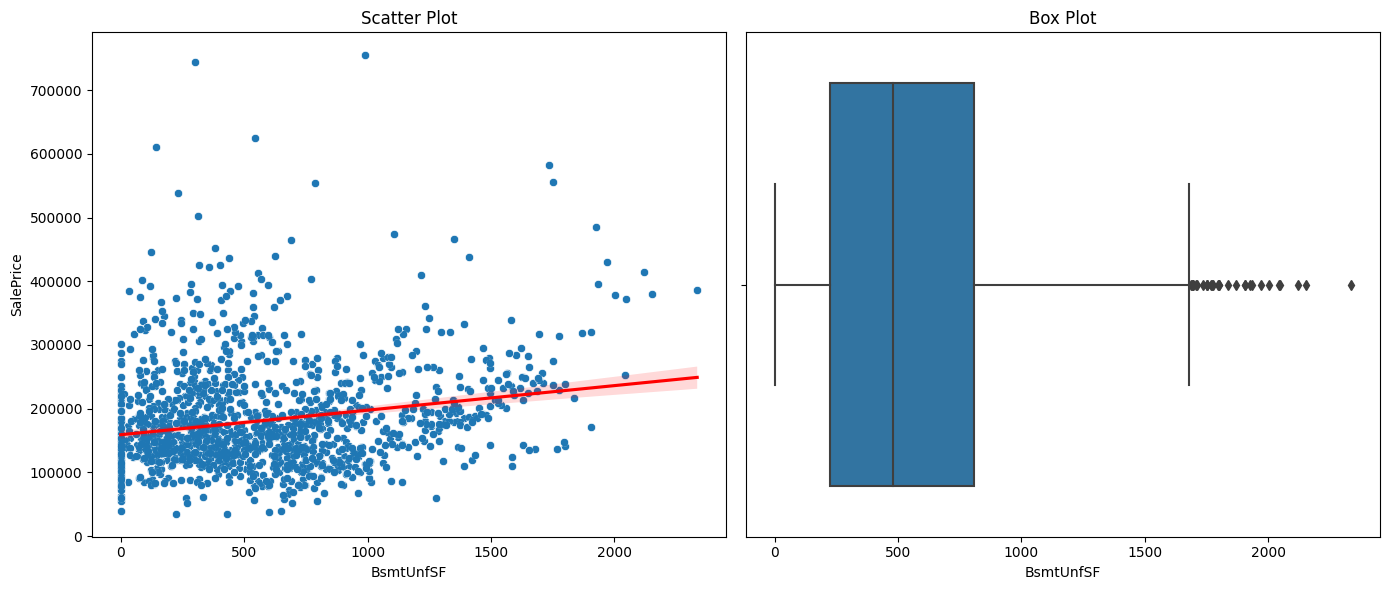

In [50]:
plt.figure(figsize=(14, 6), dpi=100)

# Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=train, x="BsmtUnfSF", y="SalePrice")
sns.regplot(data=train, x="BsmtUnfSF", y="SalePrice", scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Scatter Plot')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(data=train, x="BsmtUnfSF")
plt.title('Box Plot')


plt.tight_layout()
plt.show()

In [51]:
z_scores = stats.zscore(train['BsmtUnfSF'])
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3)
outlier_indices = np.where(outliers)[0]

outlier_values = train['BsmtUnfSF'].iloc[outlier_indices]
sorted_outlier_values_descending = outlier_values.sort_values(ascending=False)

print(sorted_outlier_values_descending)

224     2336
477     2153
278     2121
678     2046
581     2042
1267    2002
496     1969
774     1935
798     1926
137     1907
932     1905
Name: BsmtUnfSF, dtype: int64


#### TotalBsmtSF

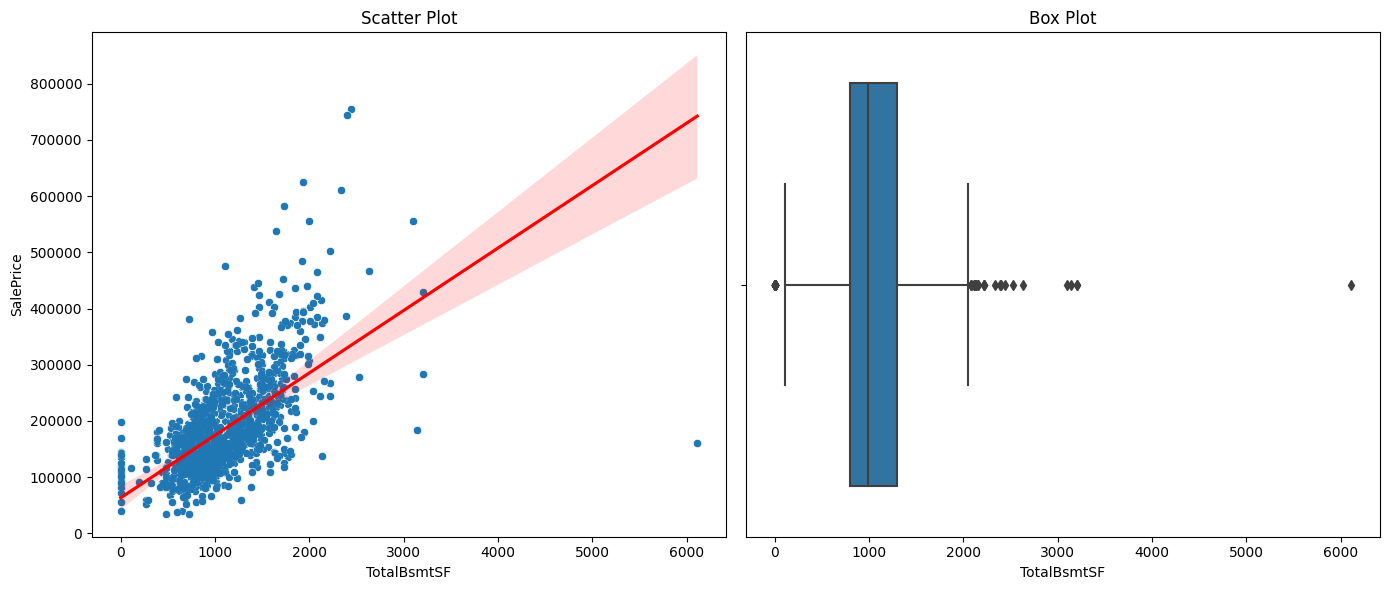

In [52]:
plt.figure(figsize=(14, 6), dpi=100)

# Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=train, x="TotalBsmtSF", y="SalePrice")
sns.regplot(data=train, x="TotalBsmtSF", y="SalePrice", scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Scatter Plot')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(data=train, x="TotalBsmtSF")
plt.title('Box Plot')


plt.tight_layout()
plt.show()

In [53]:
train.query('TotalBsmtSF > 5000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NA,IR3,Bnk,AllPub,...,480,Gd,NA,NA,0,1,2008,New,Partial,160000


In [54]:
z_scores = stats.zscore(train['TotalBsmtSF'])
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3)
outlier_indices = np.where(outliers)[0]

outlier_values = train['TotalBsmtSF'].iloc[outlier_indices]
sorted_outlier_values_descending = outlier_values.sort_values(ascending=False)

print(sorted_outlier_values_descending)

1298    6110
332     3206
496     3200
523     3138
440     3094
1373    2633
1044    2524
691     2444
1182    2396
224     2392
Name: TotalBsmtSF, dtype: int64


#### 1stFlrSF

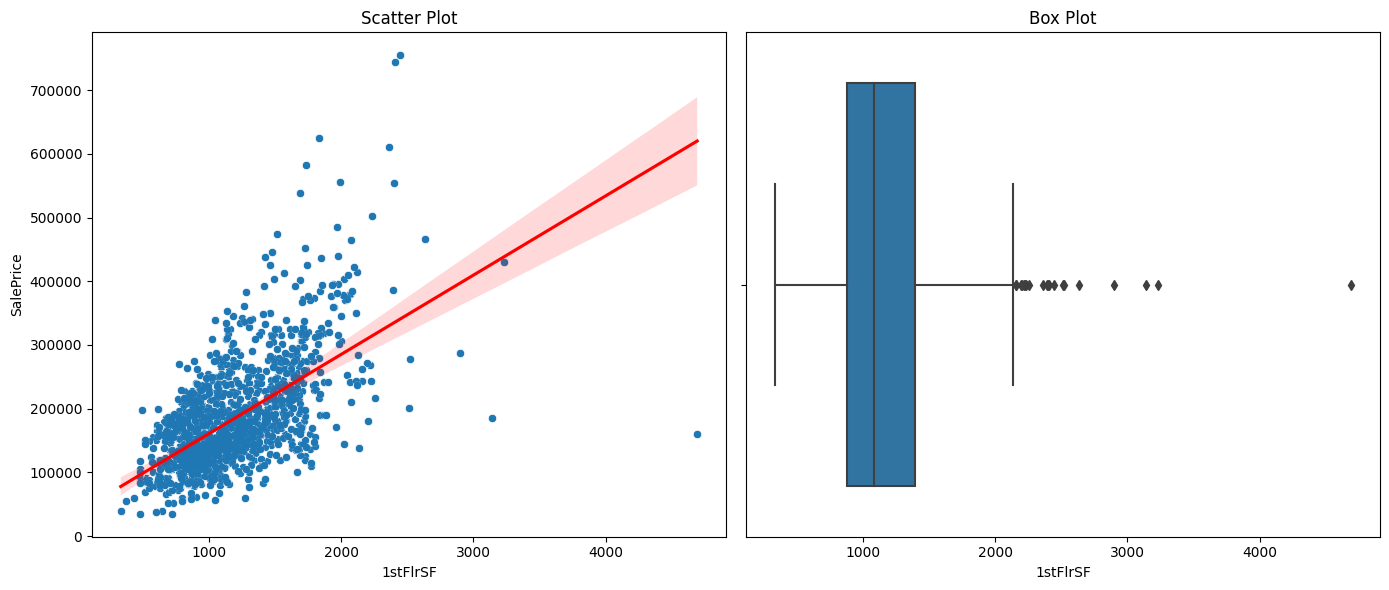

In [55]:
plt.figure(figsize=(14, 6), dpi=100)

# Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=train, x="1stFlrSF", y="SalePrice")
sns.regplot(data=train, x="1stFlrSF", y="SalePrice", scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Scatter Plot')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(data=train, x="1stFlrSF")
plt.title('Box Plot')


plt.tight_layout()
plt.show()

In [56]:
train.query('`1stFlrSF` > 4000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NA,IR3,Bnk,AllPub,...,480,Gd,NA,NA,0,1,2008,New,Partial,160000


In [57]:
z_scores = stats.zscore(train['1stFlrSF'])
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3)
outlier_indices = np.where(outliers)[0]

outlier_values = train['1stFlrSF'].iloc[outlier_indices]
sorted_outlier_values_descending = outlier_values.sort_values(ascending=False)

print(sorted_outlier_values_descending)

1298    4692
496     3228
523     3138
1024    2898
1373    2633
1044    2524
529     2515
691     2444
1182    2411
440     2402
224     2392
898     2364
Name: 1stFlrSF, dtype: int64


#### 2ndFlrSF

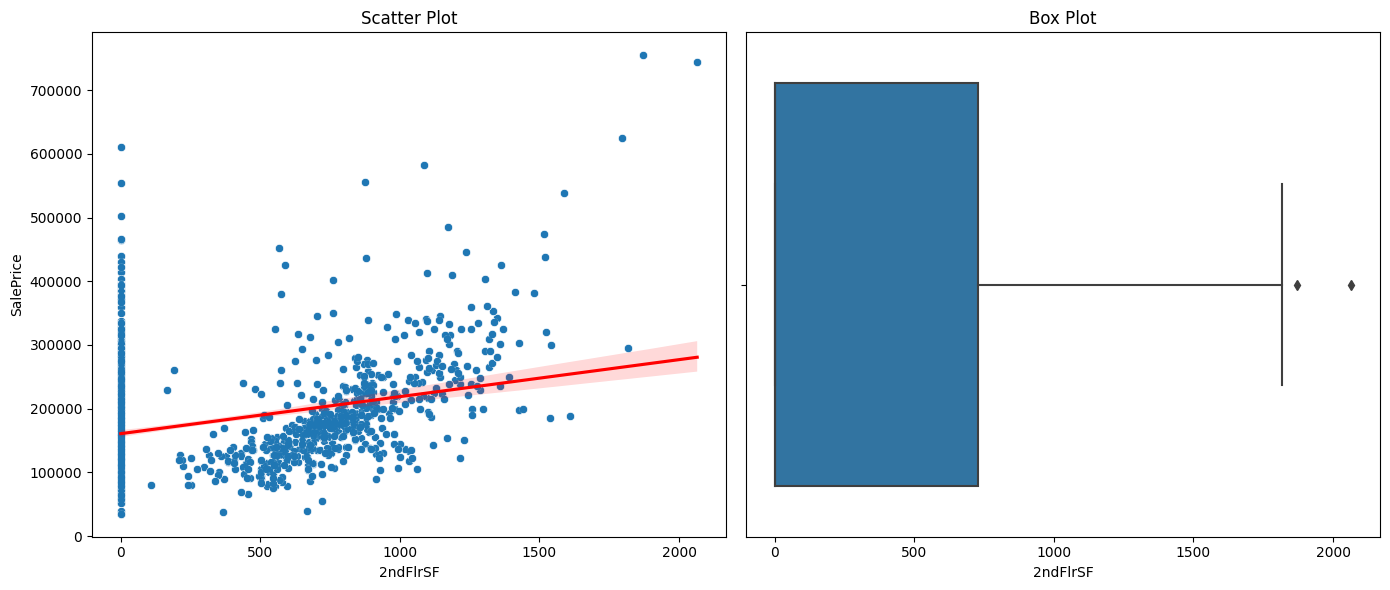

In [58]:
plt.figure(figsize=(14, 6), dpi=100)

# Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=train, x="2ndFlrSF", y="SalePrice")
sns.regplot(data=train, x="2ndFlrSF", y="SalePrice", scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Scatter Plot')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(data=train, x="2ndFlrSF")
plt.title('Box Plot')


plt.tight_layout()
plt.show()

In [59]:
z_scores = stats.zscore(train['2ndFlrSF'])
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3)
outlier_indices = np.where(outliers)[0]

outlier_values = train['2ndFlrSF'].iloc[outlier_indices]
sorted_outlier_values_descending = outlier_values.sort_values(ascending=False)

print(sorted_outlier_values_descending)

1182    2065
691     1872
304     1818
1169    1796
Name: 2ndFlrSF, dtype: int64


#### LowQualFinSF

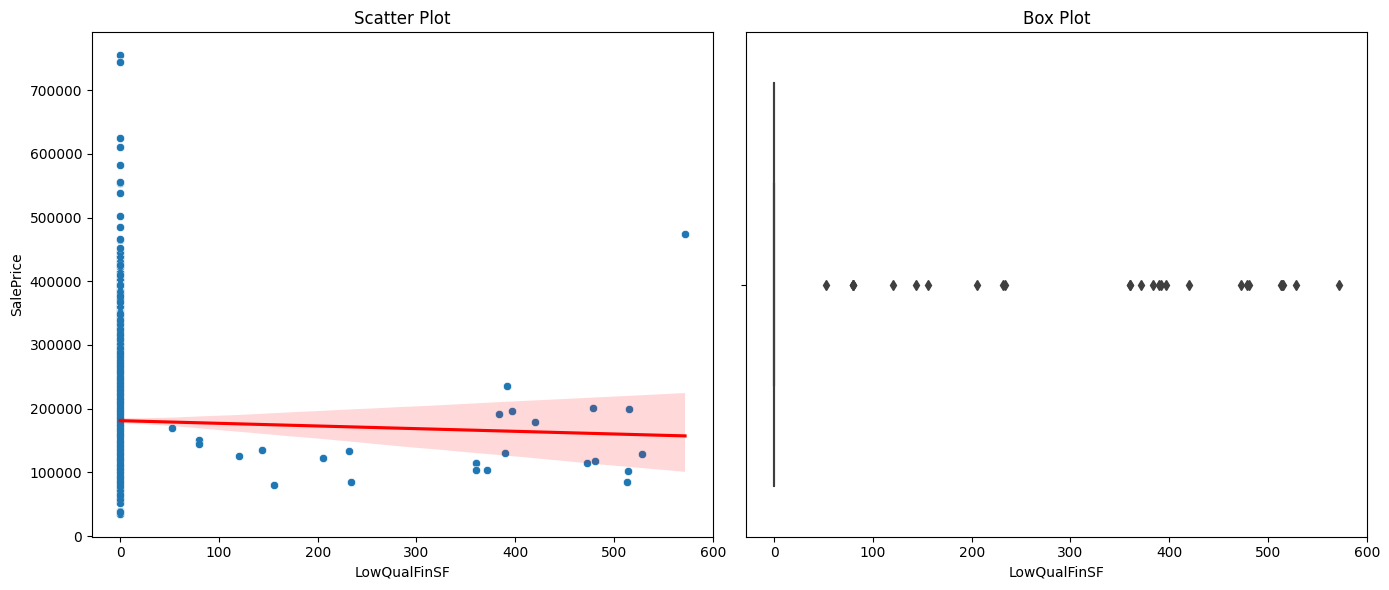

In [60]:
plt.figure(figsize=(14, 6), dpi=100)

# Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=train, x="LowQualFinSF", y="SalePrice")
sns.regplot(data=train, x="LowQualFinSF", y="SalePrice", scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Scatter Plot')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(data=train, x="LowQualFinSF")
plt.title('Box Plot')


plt.tight_layout()
plt.show()

In [61]:
train.query('LowQualFinSF > 500 & SalePrice > 450000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
185,186,75,RM,90.0,22950,Pave,NA,IR2,Lvl,AllPub,...,0,NA,GdPrv,NA,0,6,2006,WD,Normal,475000


In [62]:
z_scores = stats.zscore(train['LowQualFinSF'])
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3)
outlier_indices = np.where(outliers)[0]

outlier_values = train['LowQualFinSF'].iloc[outlier_indices]
sorted_outlier_values_descending = outlier_values.sort_values(ascending=False)

print(sorted_outlier_values_descending)

185     572
170     528
635     515
1009    514
88      513
883     481
1173    479
406     473
267     420
1031    397
197     392
263     390
1440    384
198     371
51      360
729     360
125     234
873     232
1349    205
589     156
Name: LowQualFinSF, dtype: int64


#### GrLivArea

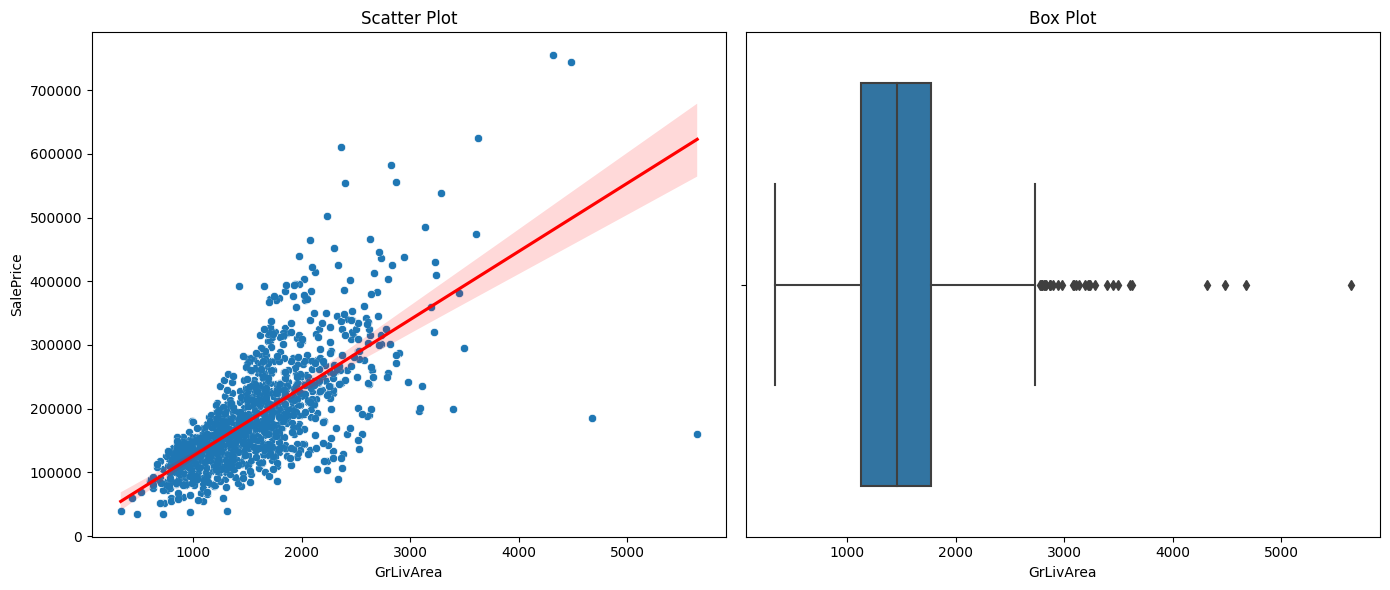

In [63]:
plt.figure(figsize=(14, 6), dpi=100)

# Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=train, x="GrLivArea", y="SalePrice")
sns.regplot(data=train, x="GrLivArea", y="SalePrice", scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Scatter Plot')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(data=train, x="GrLivArea")
plt.title('Box Plot')


plt.tight_layout()
plt.show()

In [64]:
train.query('GrLivArea > 4400 & SalePrice < 300000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NA,IR1,Bnk,AllPub,...,0,NA,NA,NA,0,10,2007,New,Partial,184750
1298,1299,60,RL,313.0,63887,Pave,NA,IR3,Bnk,AllPub,...,480,Gd,NA,NA,0,1,2008,New,Partial,160000


In [65]:
z_scores = stats.zscore(train['GrLivArea'])
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3)
outlier_indices = np.where(outliers)[0]

outlier_values = train['GrLivArea'].iloc[outlier_indices]
sorted_outlier_values_descending = outlier_values.sort_values(ascending=False)

print(sorted_outlier_values_descending)

1298    5642
523     4676
1182    4476
691     4316
1169    3627
185     3608
304     3493
1268    3447
635     3395
769     3279
1353    3238
496     3228
118     3222
608     3194
798     3140
197     3112
Name: GrLivArea, dtype: int64


#### GarageArea

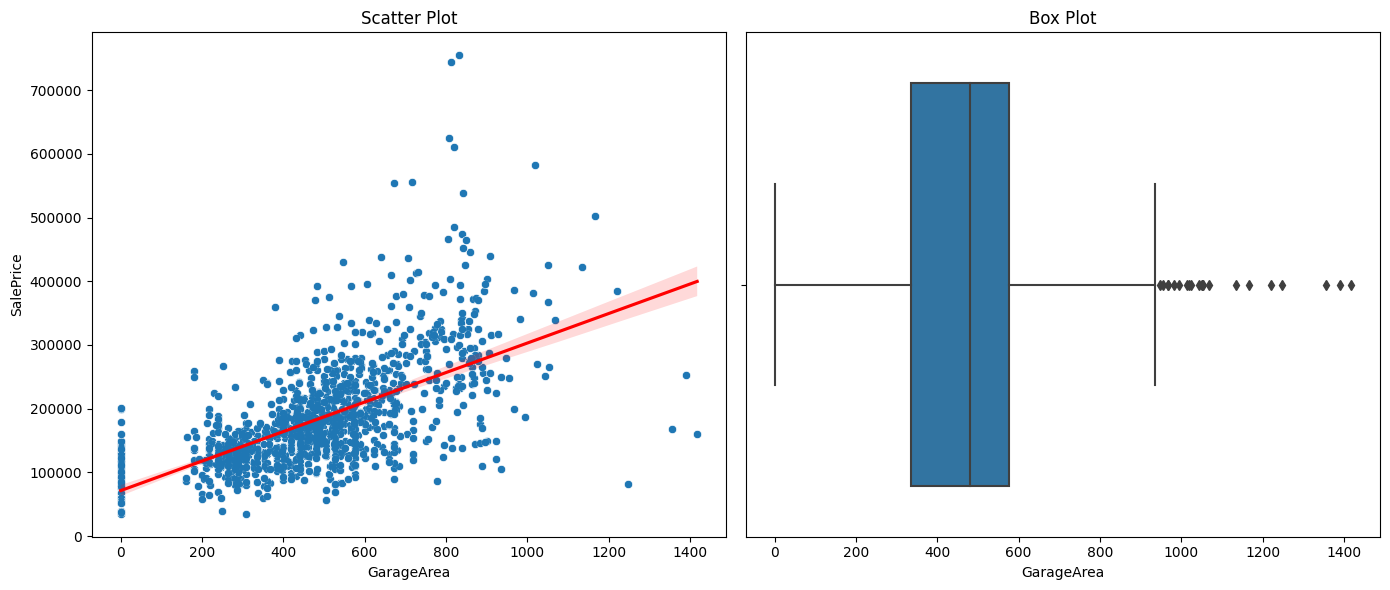

In [66]:
plt.figure(figsize=(14, 6), dpi=100)

# Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=train, x="GarageArea", y="SalePrice")
sns.regplot(data=train, x="GarageArea", y="SalePrice", scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Scatter Plot')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(data=train, x="GarageArea")
plt.title('Box Plot')


plt.tight_layout()
plt.show()

In [67]:
train.query('GarageArea > 1200 & SalePrice < 100000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1061,1062,30,C (all),120.0,18000,Grvl,NA,Reg,Low,AllPub,...,0,NA,NA,Shed,560,8,2008,ConLD,Normal,81000


In [68]:
z_scores = stats.zscore(train['GarageArea'])
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3)
outlier_indices = np.where(outliers)[0]

outlier_values = train['GarageArea'].iloc[outlier_indices]
sorted_outlier_values_descending = outlier_values.sort_values(ascending=False)

print(sorted_outlier_values_descending)

1298    1418
581     1390
1190    1356
1061    1248
825     1220
178     1166
664     1134
Name: GarageArea, dtype: int64


#### WoodDeckSF

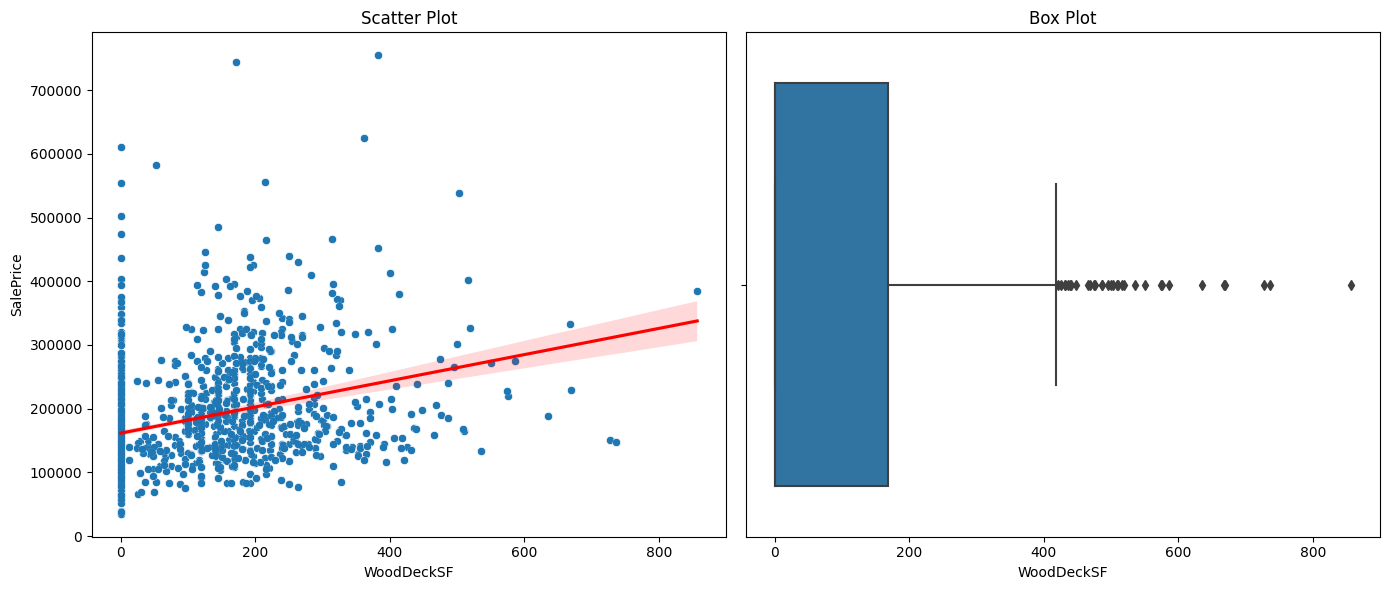

In [69]:
plt.figure(figsize=(14, 6), dpi=100)

# Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=train, x="WoodDeckSF", y="SalePrice")
sns.regplot(data=train, x="WoodDeckSF", y="SalePrice", scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Scatter Plot')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(data=train, x="WoodDeckSF")
plt.title('Box Plot')


plt.tight_layout()
plt.show()

#### OpenPorchSF

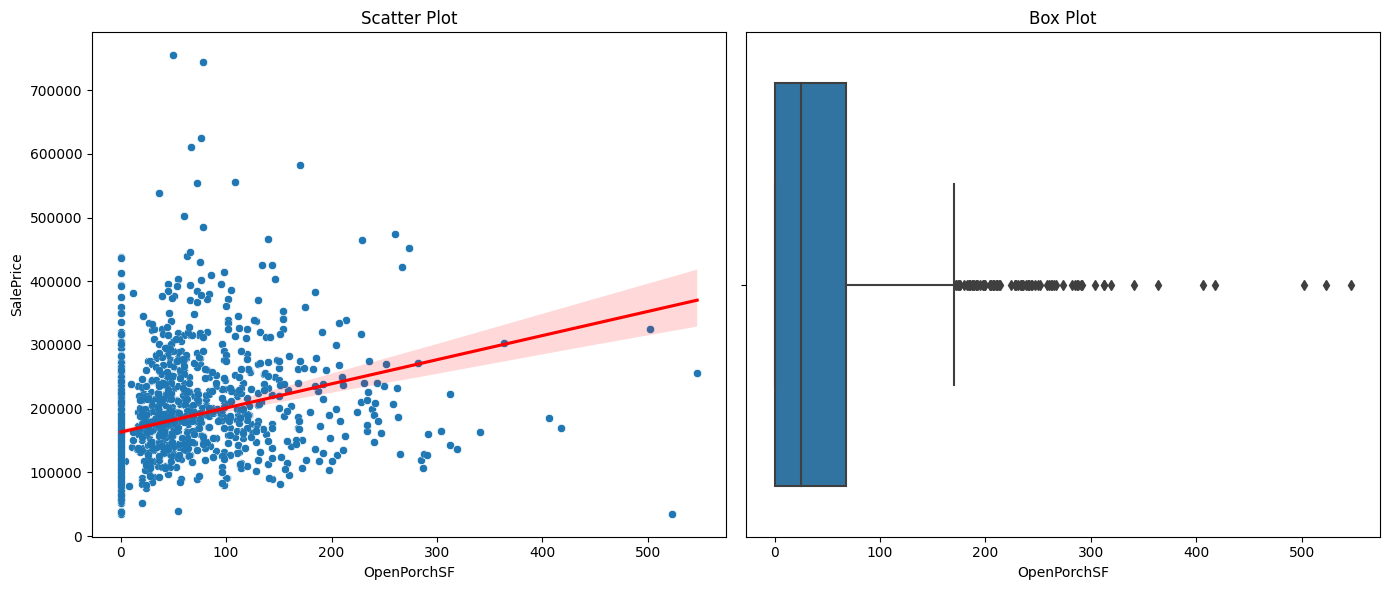

In [70]:
plt.figure(figsize=(14, 6), dpi=100)

# Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=train, x="OpenPorchSF", y="SalePrice")
sns.regplot(data=train, x="OpenPorchSF", y="SalePrice", scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Scatter Plot')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(data=train, x="OpenPorchSF")
plt.title('Box Plot')


plt.tight_layout()
plt.show()

In [71]:
train.query('OpenPorchSF > 500 & SalePrice < 100000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
495,496,30,C (all),60.0,7879,Pave,NA,Reg,Lvl,AllPub,...,0,NA,GdWo,NA,0,11,2009,WD,Abnorml,34900


In [72]:
z_scores = stats.zscore(train['OpenPorchSF'])
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3)
outlier_indices = np.where(outliers)[0]

outlier_values = train['OpenPorchSF'].iloc[outlier_indices]
sorted_outlier_values_descending = outlier_values.sort_values(ascending=False)

print(sorted_outlier_values_descending)

1328    547
495     523
583     502
854     418
523     406
875     364
735     341
996     319
645     312
807     312
1193    304
1298    292
784     291
713     288
1292    287
499     285
961     282
591     274
664     267
666     265
1184    263
1369    262
185     260
28      258
947     252
293     250
775     247
Name: OpenPorchSF, dtype: int64


### I'm dropping outliers

In [73]:
train.drop([523, 1298, 1337, 934, 297, 440, 185, 495],axis=0,inplace=True)

# Feature Engineering

### totalsf(Total Square Feet)

In [74]:
train['totalsf'] = train['1stFlrSF'] + train['2ndFlrSF'] + train['BsmtFinSF1'] + train['BsmtFinSF2']
test['totalsf'] = test['1stFlrSF'] + test['2ndFlrSF'] + test['BsmtFinSF1'] + test['BsmtFinSF2']

### Total Area

In [75]:
train['totalarea'] = train['GrLivArea'] + train['TotalBsmtSF']
test['totalarea'] = test['GrLivArea'] + test['TotalBsmtSF']

# Skewness

Mu - Average

Sigma - Standard Deviation

If the mean is close to 0 and the standard deviation is close to 1, we know that there may be a normal distribution.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



 mu = 180579.75 and sigma = 78448.96



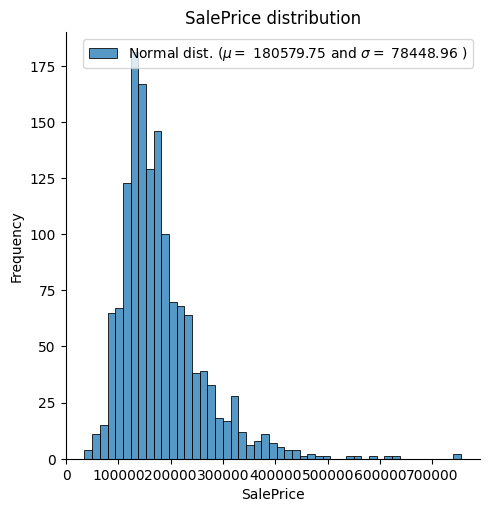

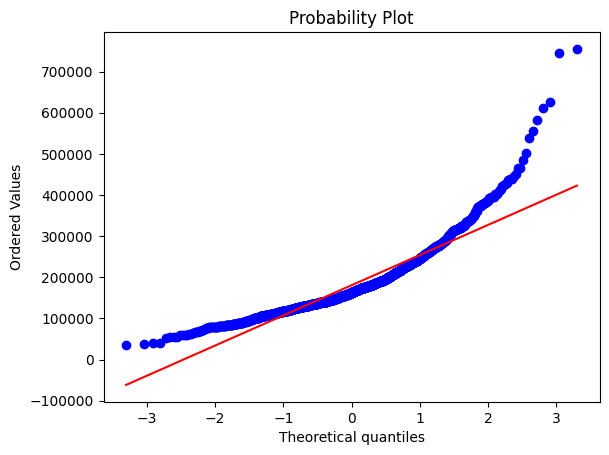

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, probplot

# Plotting the histogram of SalePrice
sns.displot(train['SalePrice'], kde_kws={'fit': norm})

# Get the suitable parameters for distribution
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Adding legend and other plot details
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# Plotting QQ-plot
fig, ax = plt.subplots()
probplot(train['SalePrice'], plot=ax)
plt.show()


+ In this data, we have a right skewed distribution where most of the Sales are between 0 and 340K.
+ Since it is Right Skewed here, using Logarithm helps us to have a normal distribution.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



 mu = 12.02 and sigma = 0.39



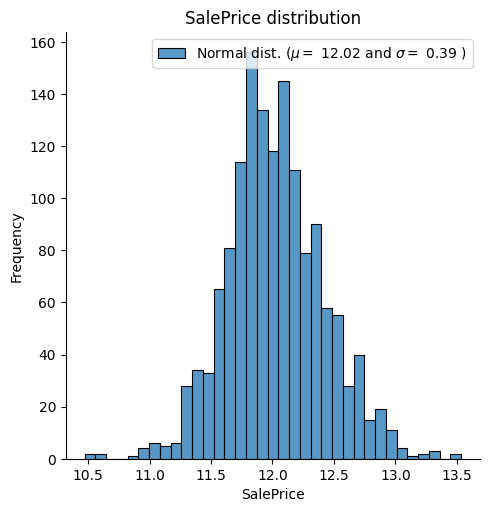

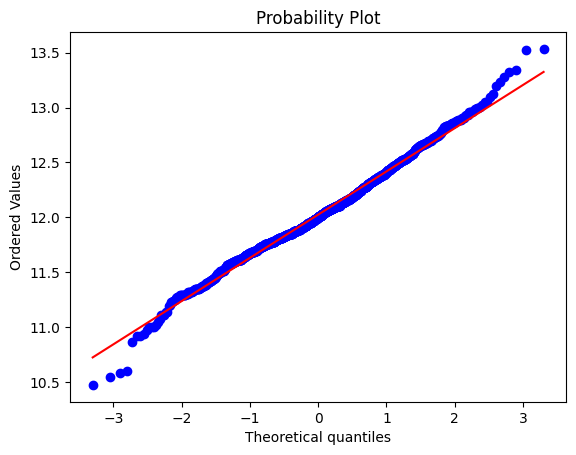

In [77]:
# Apply log transformation to SalePrice
train["SalePrice"] = np.log1p(train["SalePrice"])

# Plotting the histogram of SalePrice
sns.displot(train['SalePrice'], kde_kws={'fit': norm})

# Get the suitable parameters for distribution
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Adding legend and other plot details
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# Plotting QQ-plot
fig, ax = plt.subplots()
probplot(train['SalePrice'], plot=ax)
plt.show()

# Encoding

In [78]:
# We save the line numbers. We will split the data we will merge later back into train and test.
ntrain = train.shape[0]

# Target Variable
y_train = train.SalePrice.values

# Merges the training and test datasets. Resets the indexes.
all_data = pd.concat((train, test)).reset_index(drop=True)

# Drops the 'SalePrice' column.
all_data.drop(['SalePrice'], axis=1, inplace=True)

print("all_data size is: {}".format(all_data.shape))

all_data size is: (2911, 82)


In [79]:
ccol = all_data.dtypes[train.dtypes == "object"].index
ccol

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

**I am doing Label Encoding to columns that have numerical superiority within themselves. So that the connection between them won't be disrupted.**

In [80]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir')

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

In [81]:
print(all_data.shape)

(2911, 82)


**I apply One-Hot Encoding to the remaining columns.**

In [82]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2911, 239)


In [83]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# Model

## XGBoost

In [84]:
X = train
y = y_train

In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [86]:
# import optuna

# def objective(trial):
#     # Define the hyperparameters of the model
#     params = {
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
#         'gamma': trial.suggest_float('gamma', 0, 5),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
#         'max_depth': trial.suggest_int('max_depth', 1, 10),
#         'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
#         'subsample': trial.suggest_float('subsample', 0.1, 1),
#         'random_state': 7,
#         'nthread': -1
#     }

#     # Create the XGBoost model
#     model_xgb = xgb.XGBRegressor(**params)

#     # Train the model
#     model_xgb.fit(X_train, y_train)

#     # Make predictions on the test set
#     y_pred = model_xgb.predict(X_test)

#     # Calculate error metrics (e.g., MSE)
#     error = mean_squared_error(y_test, y_pred)

#     return error

# # Start Bayesian optimization with Optuna
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# # Print the best parameters and error value
# print('Best parameters:', study.best_params)
# print('Best error:', study.best_value)


In [87]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.6306375237479561, gamma=0.015480506488872808, 
                             learning_rate=0.03803462652289773, max_depth=3, 
                             min_child_weight=3.827233401116889, n_estimators=2938,
                             reg_alpha=0.34207462260540195, reg_lambda=0.9201728490366174,
                             subsample=0.45085817733038025,
                             random_state =7, nthread = -1)

In [88]:
model_xgb.fit(X_train, y_train)
xgb_pred = model_xgb.predict(X_test)

In [89]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Calculate error metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_pred))
r2_xgb = r2_score(y_test, xgb_pred)

print(f'RMSE: {rmse_xgb:.4f}')
print(f'R-squared: {r2_xgb:.4f}')

RMSE: 0.1234
R-squared: 0.9092


In [90]:
# Assign the return value of the cross_val_score function to the scores variable when used with your actual data.
scores = cross_val_score(model_xgb, X, y, cv=5)

# For example, let's print the performance of the model:
print("Cross validation scores:", scores)
print("Mean cross validation score:", scores.mean())

# Let's define our custom scorer function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Update the scorer parameter of cross_val_score with the rmse function
scores = cross_val_score(model_xgb, X, y, cv=5, scoring=make_scorer(rmse))

# Print RMSE values
print("RMSE values:", scores)
print("Mean RMSE value:", scores.mean())

Cross validation scores: [0.91727318 0.92193542 0.90874531 0.91926387 0.91240244]
Mean cross validation score: 0.9159240421397545
RMSE values: [0.10998695 0.11521912 0.12330336 0.10819658 0.11436648]
Mean RMSE value: 0.11421449878454445


# Test

In [91]:
# We applied a logarithmic transformation. We need to convert it back to its original scale and predict the test accordingly.
test_pred = np.expm1(model_xgb.predict(test))

In [92]:
print(test_pred)

[122609.89 167083.61 184396.03 ... 162997.19 110332.44 221821.19]


# Submission

In [93]:
sub = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv") 
sub

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [94]:
len(test_pred)

1459

In [95]:
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = test_pred
sub.to_csv('submission.csv',index=False)